# Tronos Analysis
## Introduction
Welcome to Tronos Analysis. In this notebook, group analysis of chromosome trajectories is possible. There are two types of cells; _markdown_ cells such as this, with text content containing explanations about the analysis methodology and interpretation of results, and _code_ cells, which contains the snippets that may be executed with your own data.

Refer to the latest up-to-date Notebooks at https://github.com/danilexn/tronos
Please, cite this work when using the Tronos workflow

## Configuring parameters
In the following cell, you may want to configure some settings that will be used throughout the rest of the analysis, such as Pixel Sizel, Moving Average smoothing order, the sampling time in seconds and the subtitles for most of the plots.

In [34]:
pixel.size <- 0.066 # Microns (indicate 1 if already set in source file)
ma.order <- 12
sampling.time <- 60 # Seconds
spectrum.plot.subtitle <- "AFA226 (wt) vs. AFA851 (pht1D)"
folder.route <- "/Users/danielleon/Notebooks/Tronos/20200901"

In [13]:
# Load libraries
if (!require("spdep")) {
  # This is in Linux (Google Colab). macOS uses a different approach for package installation
  system("apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev", intern=TRUE)
  install.packages("units")
  install.packages("sf")
  install.packages("spdep")
  library("spdep")
}

if (!require("forecast")) {
  install.packages("forecast")
}

if (!require("dplyr")) {
  install.packages("dplyr")
  library("dplyr")
}

if (!require("ggplot2")) {
  install.packages("ggplot2")
  library("ggplot2")
}

if (!require("segclust2d")) {
  install.packages("segclust2d")
  library("segclust2d")
}

if (!require("dplR")) {
  packageurl <- "https://cran.rstudio.com//src/contrib/Archive/XML/XML_3.99-0.3.tar.gz"
  install.packages(packageurl, repos=NULL, type="source")
  install.packages("dplR")
  library("dplR")
}

if (!require("tsmp")) {
  install.packages("tsmp")
  library("tsmp")
}

if (!require("mclust")) {
  install.packages("mclust")
  library("mclust")
}

if (!require("lmtest")) {
  install.packages("lmtest")
  library("lmtest")
}

Loading required package: spdep

Loading required package: sf

Error: package or namespace load failed for ‘sf’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so, 6): Library not loaded: /usr/lib/libpq.5.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so
  Reason: image not found



ERROR: Error in system("apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev", : error in running command


## Loading data
The folder that you previously gave as parameter is going to be explored for CSV files.
Please, make sure that data in CSV files complies the Tronos-output format, having the following columns (any order is possible):

_frame, y, x, minor, major, area, convexity, perimeter, circularity,particle,label_

The time variable is specified after the df\\$times <- [], where [] is the variable in df\\$variable format that represents time, in seconds. Please, re-scale your variable to represent seconds. It is also possible to filter out unwanted cell types or features from your analysis: please, modify the cell below to adjust the data, following dplyr syntax as in the rest of the notebook.

You may also specify a timepoint 0 different from frame 1 with feature-linking. Please, refer to the instructions in https://github.com/danilexn/tronos

In [35]:
setwd(folder.route)
file.names <- dir(folder.route, pattern="226vs851.csv")
df <- do.call(rbind,lapply(file.names,read.csv))
if (length(df) < 1){
    stop("Data could not be loaded!")
}

## Specifying which is time
df$times <- df$frame

## Re-scale variables
df$x <- (df$x - min(df$x))*pixel.size
df$y <- (df$y - min(df$y))*pixel.size
df[,c("minor","major")] <- df[,c("minor","major")]*pixel.size
df$area <- df$area*pixel.size*pixel.size
df$radius <- sqrt(df$area/3.14)

## Rotating cell coordinates
As cells may be oriented in different angles, a critical step of oscillation analysis is to homogeneize axis across them, making measures comparable. In the following cell, _best rotation_ is calculated to make the Y axis the greatest varying, and X the least varying. If you do not execute this cell, please consider that trajectory is going to be extracted from the Y axis, anyway.

In [120]:
library(spdep)
library(dplyr)

homogeneize.rotation <- function(x, y){
    
    coords <- cbind(X = x, Y = y)
    rad <- seq(0, pi, l=20)
    opar <- par(mfrow=c(5,4), mar=c(3,3,1,1))
    best.rotation <- c()
    for(i in rad){
        coords.rot <- Rotation(coords, i)
        best.rotation <- c(best.rotation, abs(max(coords.rot[,1])-min(coords.rot[,1])))
    }

    rot <- rad[which.min(best.rotation)]
    coords.rot <- Rotation(coords, rot)
    return(coords + 1)
}

df %>% group_by(particle) %>% 
  mutate(x = homogeneize.rotation(x, y)[1], y = homogeneize.rotation(x, y)[2])

Loading required package: sf

Error: package or namespace load failed for ‘sf’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so, 6): Library not loaded: /usr/lib/libpq.5.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/sf/libs/sf.so
  Reason: image not found



ERROR: Error: package ‘sf’ could not be loaded


## Sequence spectrum
There are two domains that can be considered in this analysis: time domain, as the change in position over time, and frequency domain, as the richness of frequencies of this behaviour; in summary, frequential-spectral analysis allows to assay the composition of periodicities or frequencies of a given time series, as a measure of how it can be repetitive or oscillatory. Spectral density, represented in the Trajectory periodicity plot below, may present peaks around the frequencies that arise from the change in position over time. As an example, a frequency of 2.7e-03 Hz or a period of around 6 minutes indicates that the trajectory is repetitive in 6 minutes intervals. Presence of various peaks may indicate that there are different periodicities at the same time, or that in the same time series, there is first a dominant frequency, then other dominant frequency (maybe to a conservation in movement amplitude but with different velocity).

`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



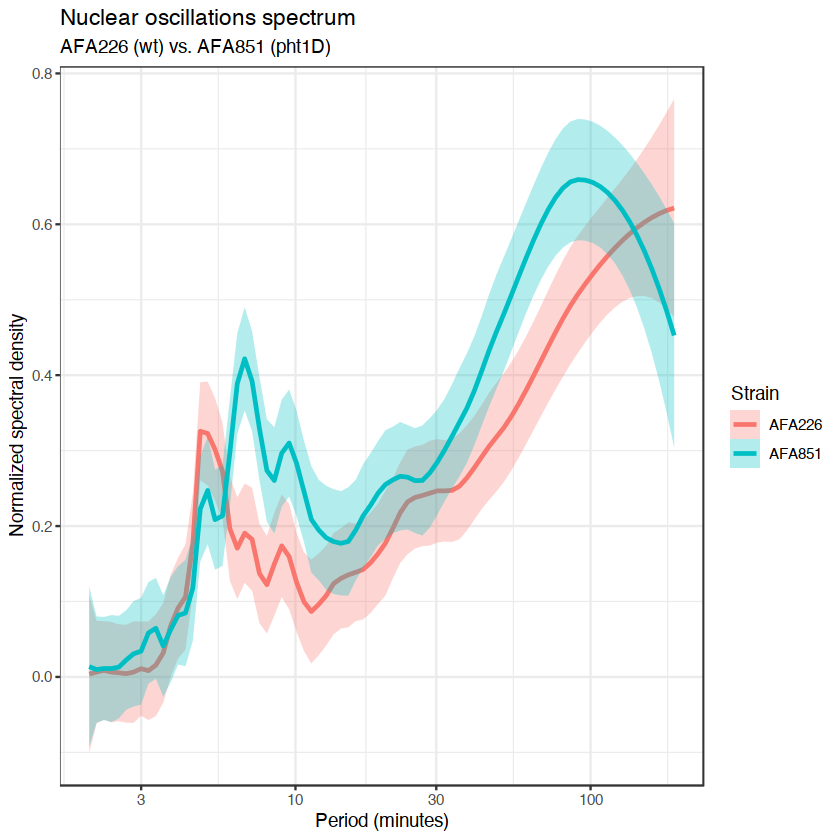

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



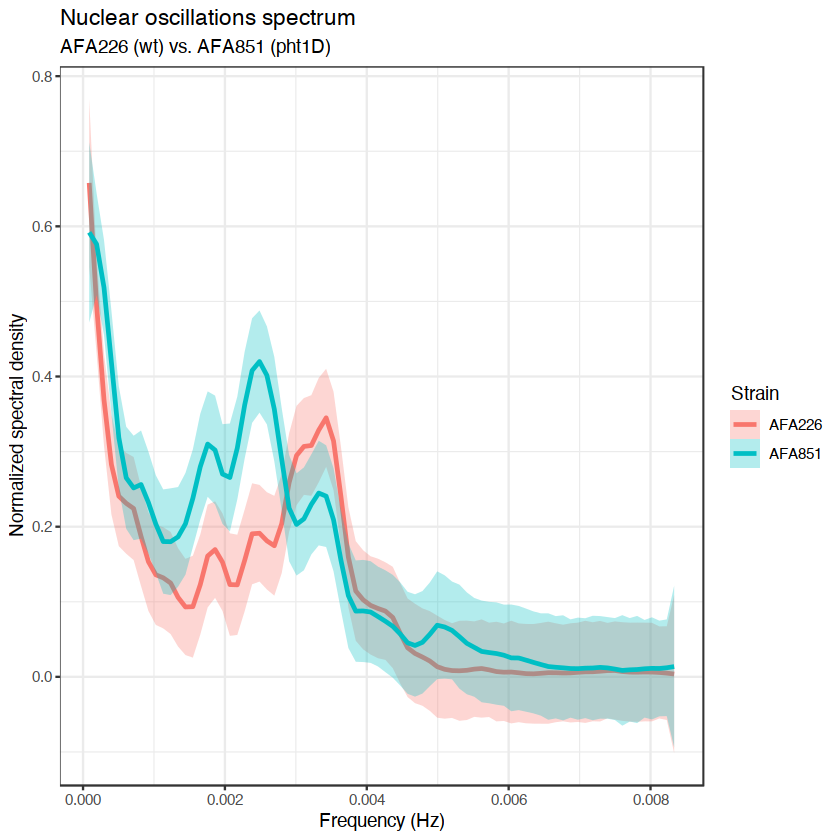

In [36]:
calculate.spectrum <- function(y){
    y.spec <- spectrum(y,log="yes",span=2,plot=FALSE)
    spy <- 2*y.spec$spec
    if (length(y) > length(spy)){
        spy<-spy[1:length(y)]
    }
    return(spy)
}

calculate.freqs <- function(y){
    y.spec <- spectrum(y,log="yes",span=2,plot=FALSE)
    spx <- y.spec$freq/sampling.time
    if (length(y) > length(spx)){
        spx<-spx[1:length(y)]
    }
    return(spx)
}

normalize <- function(x) {
    return((x-min(x))/(max(x)-min(x)))
}

# Generate the dataframe which contains all spectral data

df_freqs <- df %>% group_by(particle) %>% 
            mutate(spec.s = calculate.spectrum(y), spec.f = calculate.freqs(y)) %>%
            na.omit() %>% mutate(spec.s = normalize(spec.s))

# Generate plots

p.period <- ggplot(df_freqs, aes((1/spec.f)/60, spec.s), colour=label) +
  ggtitle(label = "Nuclear oscillations spectrum", subtitle = spectrum.plot.subtitle) +
  stat_smooth(method="loess", span=0.1, se=TRUE, aes(color = label, fill = label), alpha=0.3) +
  theme_bw() +
  labs(color="Strain", fill="Strain") +
  ylab("Normalized spectral density") + 
  scale_x_continuous(trans = "log10") +
  xlab("Period (minutes)")

p.freq <- ggplot(df_freqs, aes(spec.f, spec.s), colour=label) +
  ggtitle(label = "Nuclear oscillations spectrum", subtitle = spectrum.plot.subtitle) +
  stat_smooth(method="loess", span=0.1, se=TRUE, aes(color = label, fill = label), alpha=0.3) +
  labs(color="Strain", fill="Strain") +
  theme_bw() +
  ylab("Normalized spectral density") + 
  xlab("Frequency (Hz)")

p.period
ggsave("period_comparison.pdf")
p.freq
ggsave("frequency_comparison.pdf")

## Velocity calculation
Velocity is calculated as the vector modulo, for the X and Y positions specified in the source files. This way, speed is invariant on the previous rotation. A moving average smoothing can also take place: this method allows to reduce extreme peaks or variation in a univariate time series, hence allowing to perform the following analysis more easily (i.e., segmentation analysis).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



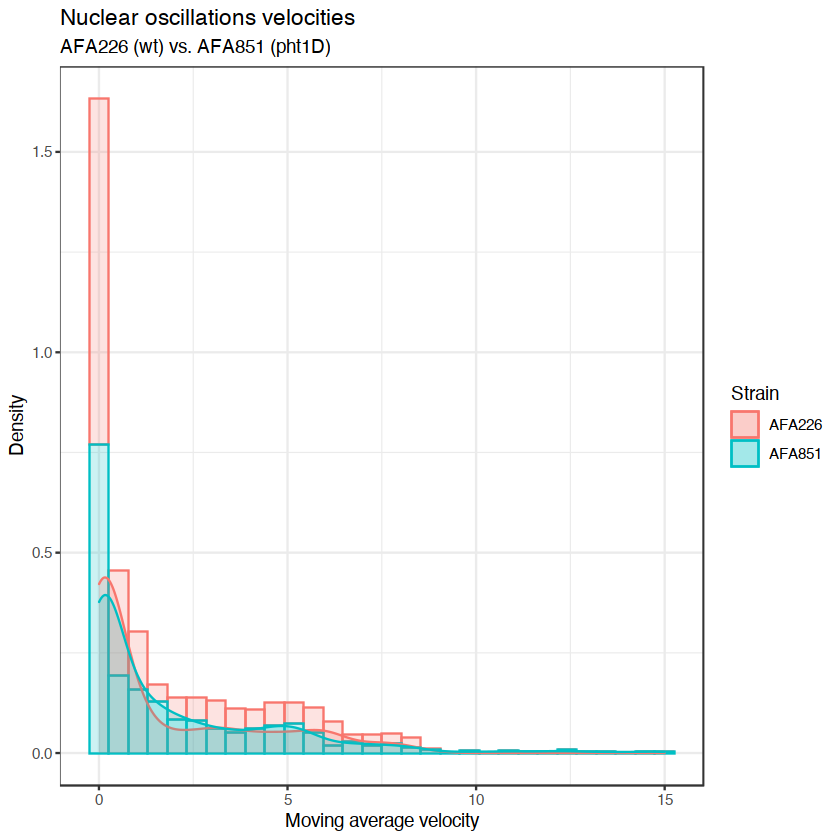

In [37]:
calculate.velocity <- function(y, x){
    vt <- diff(y)^2+diff(x)^2
    if (length(y) > length(vt)){
        vt<-vt[1:length(y)]
    }
    return(vt)
}

calculate.velocity.ma <- function(y, x){
    vt <- diff(y)^2+diff(x)^2
    vt.smooth <- forecast::ma(vt, order = ma.order)
    if (length(y) > length(vt.smooth)){
        vt.smooth<-vt.smooth[1:length(y)]
    }
    return(vt.smooth)
}

df_vt <- df %>% group_by(particle) %>% 
            mutate(vel = calculate.velocity(y, x)) %>%
            na.omit()

df_vt.smooth <- df %>% group_by(particle) %>% 
            mutate(vel.ma = calculate.velocity.ma(y, x)) %>%
            na.omit()

p.vt.smooth <- ggplot(df_vt.smooth, aes(x=vel.ma, fill=label, color = label)) +
    ggtitle(label = "Nuclear oscillations velocities", subtitle = spectrum.plot.subtitle) +
    geom_histogram(alpha=0.2,aes(y=..density..)) + 
    geom_density(alpha=0.2,aes(y=..density..)) + 
    theme_bw() +
    labs(color="Strain", fill="Strain") +
    theme_bw() +
    xlab("Moving average velocity") + 
    ylab("Density")

p.vt.smooth

## Morphologies 
The following plots represent the most interesting morphological descriptors, being convexity, circularity, major axis and minor axis. This way, it can be visualized how different segments can comprise the nuclear oscillations, and how different morphology classes can be considered.

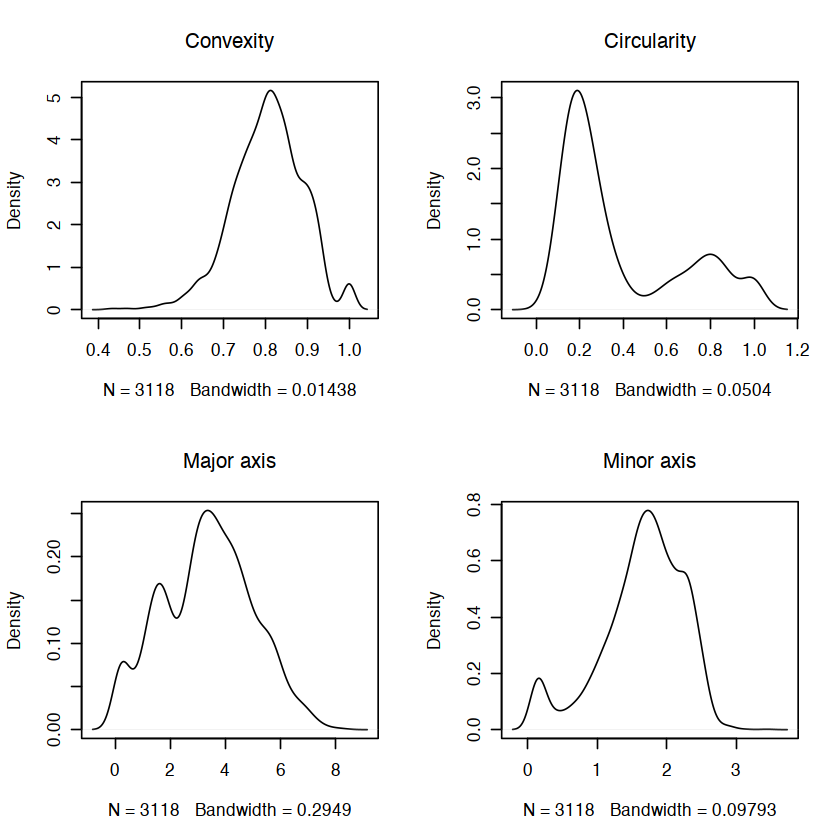

In [27]:
# Distributions for the morphologies
par(mfrow = c(2,2))
plot(density(df$convexity), main = "Convexity")
plot(density(df$circularity), main = "Circularity")
plot(density(df$major), main = "Major axis")
plot(density(df$minor), main = "Minor axis")

## Time series segmentation
Thanks to the segclust2d library, segmentation of the trajectory and convexity is possible, at once. This segmentation means that the lapse of nuclear oscillations is composed of different moments, and the conservation and distribution of these segments may give an idea of the possible biological meaning of each. This number of segments is selected after the best Likelihood explained by the Lavielle criterium.

In [29]:
# Segmentation according to velocity and convexity; position and convexity
library(segclust2d)

convertTS <- function(Y, X) {
    df_seg <- data.frame(y=Y, x=X)
    return(df_seg[complete.cases(df_seg), ])
}

seg.velocity.convexity <- segmentation(convertTS(c(vt, 0), df$convexity), lmin = 5, Kmax = 35, seg.var = c("y", "x"))

# Best case durations of each segment
segments <- seg.velocity.convexity
seg.2 <- segments$outputs$`2 segments`$segments
durations.seg.2 <- seg.2$end - seg.2$begin
seg.3 <- segments$outputs$`3 segments`$segments
durations.seg.3 <- seg.3$end - seg.3$begin
seg.4 <- segments$outputs$`4 segments`$segments
durations.seg.4 <- seg.4$end - seg.4$begin
seg.5 <- segments$outputs$`5 segments`$segments
durations.seg.5 <- seg.5$end - seg.5$begin
seg.6 <- segments$outputs$`6 segments`$segments
durations.seg.6 <- seg.6$end - seg.6$begin

# Plot the segmentation
plot(seg.velocity.convexity)

ERROR: Error in data.frame(y = Y, x = X): arguments imply differing number of rows: 3101, 3118


## Segments and its analysis
After a number of segments is chosen thanks to the Lavielle criterium, you would want to specify which has been the preferred selection in each case, this way durations of each segment can be extrapolated for following analysis (i.e. durations in different conditions). 

An spectrogram (frequencies versus time) along with the lines in segments will be represented, to accound for a visual representation of the significance of the previous segmentation. It can be observed, in the example case, how the velocity and convexity segmentation yielded a segment configuration that is compatible with changes in the significance level of the spectrogram; hence, it may be confirmed how the segments also have different underlying periodicities or frequencies, that are different from a random walk sequence, as first observed in the spectral density plot.

In [ ]:
library(dplR)
specCols <- c("#5E4FA2", "#3288BD", "#66C2A5", "#ABDDA4", "#E6F598", 
              "#FEE08B", "#FDAE61", "#F46D43", "#D53E4F", "#9E0142")

best.case <- get(paste0("seg.", segments$Kopt.lavielle))

# Create the spectrogram
wave.out <- morlet(df$y, 1:length(df$y), p2 = 8, dj = 0.1, siglvl = 0.999) 
wavelet.plot(wave.out, reverse.y = TRUE, key.cols=specCols)
abline(v=c(best.case$end, best.case$begin), lwd = 1.5, col= c("blue","red"), lty=2)

## Motif discovery
Once segments have been discovered, you may want to explain motifs occurring in the time series, and classify different classes respect to chromosome morphology, as observed in the non-Gaussian distribution in the previous density plots. Both tsmp and mclust libraries allow to perform motif discovery and clusterization from chromosome oscillation trajectory and morphology data.

Please, take into account that, for motifs, the result for single-cell analysis may not be significant, as motifs should be regarded from the point of view of the conservation of behaviours across cells. Hence, please take this code snippet and run it with all trajectory information, rotated from a single Y axis, as the output of this notebook. Also, consider if it is neccesary to extract only one segment from each cell (i.e., concatenating all segments with higher velocity to discover common patterns). You may get those segments from the time boundaries in the segmentation object generated in the previous cell.


STOMP [==>----------------------------]   9% at 979 it/s, elapsed:  0s, eta:  2s

STOMP [==>----------------------------]   9% at 949 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 916 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 882 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 821 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 797 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 734 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 713 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 690 it/s, elapsed:  0s, eta:  3s

STOMP [==>----------------------------]   9% at 646 it/s, elapsed:  0s, eta:  4s

STOMP [==>----------------------------]   9% at 619 it/s, elapsed:  0s, eta:  4s

STOMP [==>----------------------------]   9% at 595 it/s, elapsed:  0s, eta:  4s

STOMP [==>-----


STOMP [===>---------------------------]  13% at 175 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  13% at 174 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  13% at 175 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  13% at 176 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  13% at 174 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 175 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 174 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 173 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 172 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 171 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 170 it/s, elapsed:  2s, eta: 13s

STOMP [===>---------------------------]  14% at 171 it/s, elapsed:  2s, eta: 13s

STOMP [===>----


STOMP [======>------------------------]  24% at 149 it/s, elapsed:  4s, eta: 14s

STOMP [======>------------------------]  24% at 148 it/s, elapsed:  4s, eta: 14s

STOMP [======>------------------------]  24% at 148 it/s, elapsed:  4s, eta: 13s

STOMP [======>------------------------]  24% at 148 it/s, elapsed:  4s, eta: 14s

STOMP [======>------------------------]  24% at 148 it/s, elapsed:  4s, eta: 13s

STOMP [=======>-----------------------]  24% at 147 it/s, elapsed:  4s, eta: 14s

STOMP [=======>-----------------------]  24% at 148 it/s, elapsed:  4s, eta: 13s

STOMP [=======>-----------------------]  25% at 147 it/s, elapsed:  4s, eta: 13s

STOMP [=======>-----------------------]  25% at 147 it/s, elapsed:  4s, eta: 14s

STOMP [=======>-----------------------]  25% at 146 it/s, elapsed:  4s, eta: 14s

STOMP [=======>-----------------------]  25% at 147 it/s, elapsed:  4s, eta: 14s

STOMP [=======>-----------------------]  25% at 146 it/s, elapsed:  4s, eta: 14s

STOMP [=======>


STOMP [==========>--------------------]  37% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  37% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  37% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  37% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  37% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 124 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  38% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [===========>-------------------]  39% at 125 it/s, elapsed:  8s, eta: 13s

STOMP [========


STOMP [===============>---------------]  53% at 123 it/s, elapsed: 11s, eta: 10s

STOMP [===============>---------------]  53% at 122 it/s, elapsed: 11s, eta: 10s

STOMP [===============>---------------]  53% at 123 it/s, elapsed: 11s, eta: 10s

STOMP [===============>---------------]  53% at 122 it/s, elapsed: 11s, eta: 10s

STOMP [================>--------------]  53% at 123 it/s, elapsed: 11s, eta: 10s

STOMP [================>--------------]  53% at 122 it/s, elapsed: 11s, eta: 10s

STOMP [================>--------------]  53% at 122 it/s, elapsed: 12s, eta: 10s

STOMP [================>--------------]  54% at 122 it/s, elapsed: 12s, eta: 10s

STOMP [================>--------------]  54% at 123 it/s, elapsed: 12s, eta: 10s

STOMP [================>--------------]  54% at 122 it/s, elapsed: 12s, eta: 10s

STOMP [================>--------------]  54% at 123 it/s, elapsed: 12s, eta: 10s

STOMP [================>--------------]  55% at 122 it/s, elapsed: 12s, eta: 10s

STOMP [========


STOMP [======================>--------]  75% at 127 it/s, elapsed: 15s, eta:  5s

STOMP [======================>--------]  75% at 127 it/s, elapsed: 16s, eta:  5s

STOMP [======================>--------]  75% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [======================>--------]  76% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  76% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 129 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 129 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  77% at 129 it/s, elapsed: 16s, eta:  5s

STOMP [=======================>-------]  78% at 128 it/s, elapsed: 16s, eta:  5s

STOMP [========


STOMP [=============================>-]  98% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  98% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  99% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  99% at 133 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  99% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  99% at 133 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>]  99% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>] 100% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>] 100% at 133 it/s, elapsed: 20s, eta:  0s

STOMP [==============================>] 100% at 132 it/s, elapsed: 20s, eta:  0s

STOMP [===============================] 100% at 132 it/s, elapsed: 20s, eta:  0s


Finished in 19.93 secs



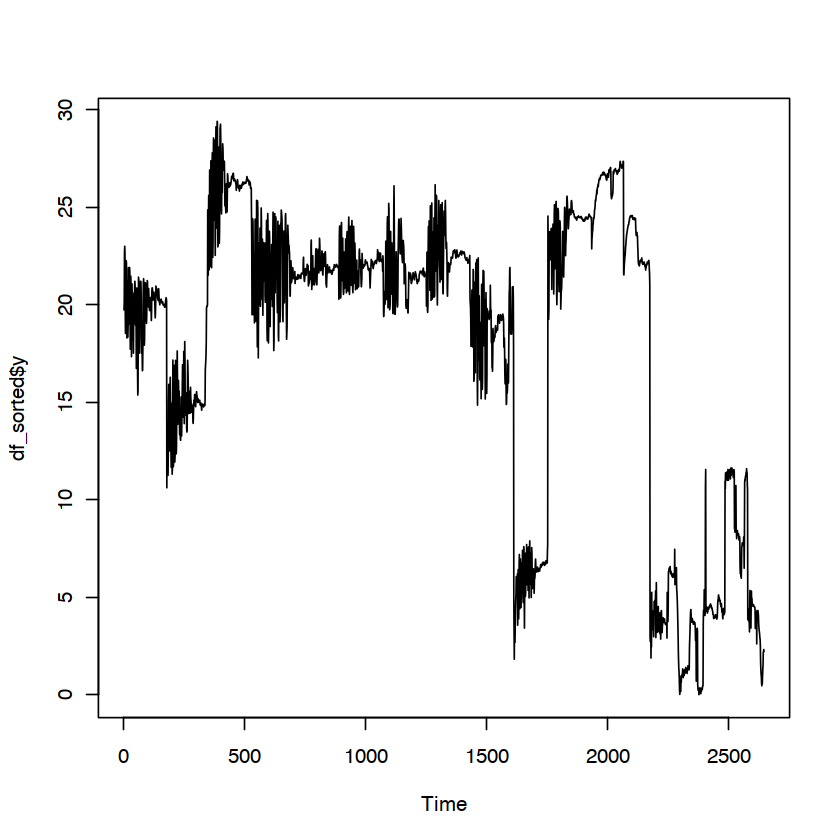

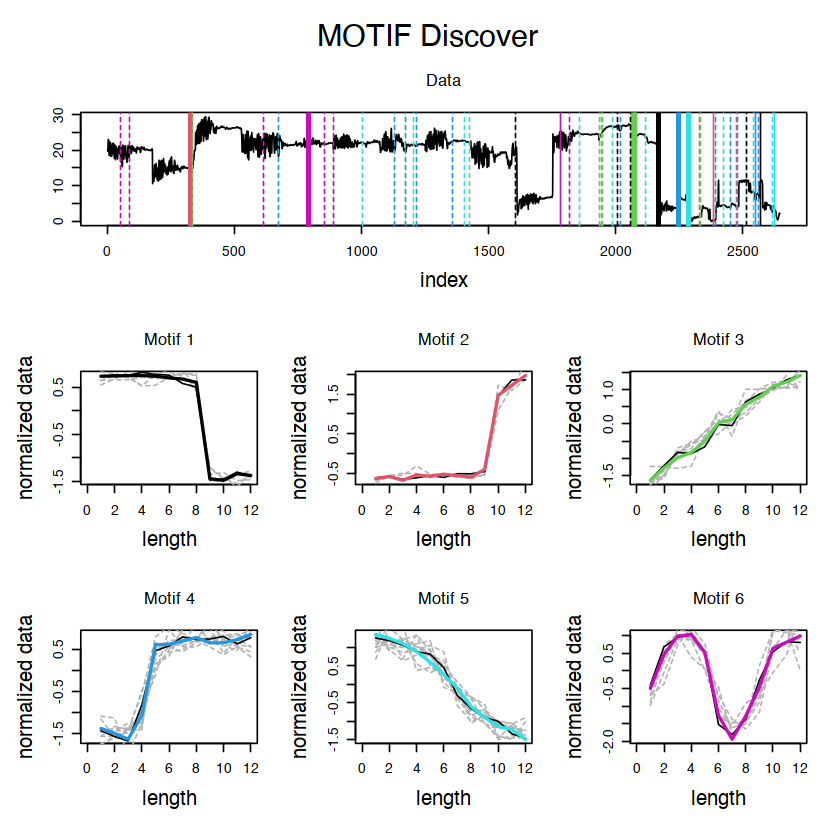

In [39]:
library(tsmp)

df_sorted <- df %>% arrange(particle)

# Trajectory motif finding
matrix <- tsmp(df_sorted$y, window_size = 12, s_size = 50, mode = "stomp")
motifs <- find_motif(matrix, n_motifs = 6)
plot(motifs)

In [ ]:
library(mclust)

# Class algorithm for morphologies
classes <- Mclust(df[,c("convexity", "circularity", "major", "minor")])
plot.Mclust(classes)

## Causality analysis
After segments have been defined, and motifs-classes have been discovered, you may want to explore causation relations between variables. For the following cell, convexity and rotated-Y trajectory are chosen as the two variables of study. You may want to dig into the code, and explore different causality relations, explained with the Granger test.